In [1]:
!pip install transformers

# Imports

In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from matplotlib import pyplot as plt
import csv

# Loading prepared train and test data

In [3]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
train_data['overview'].fillna('', inplace=True)
test_data['overview'].fillna('', inplace=True)

In [4]:
# 2. Dataset and Dataloader
class RevenueDataset(Dataset):
    def __init__(self, tokenizer, data, device, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data
        self.original_language_cols = [x for x in data.columns if x.startswith('original_language_')]
        self.genre_cols = [x for x in data.columns if x.startswith('genre_')]
        self.cast_cols = [x for x in data.columns if x.startswith('cast_')]
        self.crew_cols = [x for x in data.columns if x.startswith('crew_')]
        self.device = device

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer.encode_plus(row['overview'], add_special_tokens=True, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt').to(self.device)

        original_language = torch.tensor(row[self.original_language_cols].values.astype(float), dtype=torch.float, device=self.device)
        genres = torch.tensor(row[self.genre_cols].values.astype(float), dtype=torch.float, device=self.device)
        cast = torch.tensor(row[self.cast_cols].values.astype(float), dtype=torch.float, device=self.device)
        crew = torch.tensor(row[self.crew_cols].values.astype(float), dtype=torch.float, device=self.device)
        budget = torch.tensor(row['budget_100M'], dtype=torch.float, device=self.device)
        budget_unknown = torch.tensor(row['budget_unknown'], dtype=torch.float, device=self.device)
        revenue = torch.tensor(row['revenue_100M'], dtype=torch.float, device=self.device)

        x = torch.cat((
            inputs["input_ids"].squeeze(),
            inputs["attention_mask"].squeeze(),
            original_language,
            genres,
            cast,
            crew,
            budget.unsqueeze(0),
            budget_unknown.unsqueeze(0)
        ))

        return x, revenue

    def __len__(self):
      return len(self.data)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
BATCH_SIZE = 32

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
train_dataset = RevenueDataset(tokenizer, train_data, DEVICE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = RevenueDataset(tokenizer, test_data, DEVICE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
NUM_GENRES = len(train_dataset.genre_cols)
NUM_CAST = len(train_dataset.cast_cols)
NUM_CREW = len(train_dataset.crew_cols)
NUM_ORIGINAL_LANGUAGES = len(train_dataset.original_language_cols)

In [10]:
# 3. Model
class RevenuePredictor(nn.Module):
    def __init__(self, bert_embedding_size = 128, original_language_embedding_size = 32, cast_embedding_size = 32, crew_embedding_size = 32, hidden_size = 256):
        super(RevenuePredictor, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Linear layer for textual embeddings
        self.linear_overview = nn.Linear(self.bert.config.hidden_size, bert_embedding_size)

        # Linear layer for original language embeddings
        self.linear_original_language = nn.Linear(NUM_ORIGINAL_LANGUAGES, original_language_embedding_size)

        # Linear layer for embedding cast
        self.linear_cast = nn.Linear(NUM_CAST, cast_embedding_size)

        # Linear layer for embedding crew
        self.linear_crew = nn.Linear(NUM_CREW, crew_embedding_size)

        # Budget and budget_unknown, and genres
        self.other_features_size = 2 + NUM_GENRES

        self.output_layer = nn.Sequential(
            nn.Linear(bert_embedding_size + original_language_embedding_size + cast_embedding_size + crew_embedding_size + self.other_features_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input):
        bert_out = self.bert(input_ids=input[:, :256].long(), attention_mask=input[:, 256:512].long())
        overview_embedding = self.linear_overview(bert_out['pooler_output'])
        overview_embedding = nn.LeakyReLU()(overview_embedding)

        original_language_embedding = self.linear_original_language(input[:, 512:512+NUM_ORIGINAL_LANGUAGES])
        original_language_embedding = nn.LeakyReLU()(original_language_embedding)
        cast_embedding = self.linear_cast(input[:, 512+NUM_ORIGINAL_LANGUAGES:512+NUM_ORIGINAL_LANGUAGES+NUM_CAST])
        cast_embedding = nn.LeakyReLU()(cast_embedding)
        crew_embedding = self.linear_crew(input[:, 512+NUM_ORIGINAL_LANGUAGES+NUM_CAST:512+NUM_ORIGINAL_LANGUAGES+NUM_CAST+NUM_CREW])
        cast_embedding = nn.LeakyReLU()(cast_embedding)
        other_features = input[:, 512+NUM_ORIGINAL_LANGUAGES+NUM_CAST+NUM_CREW:]


        return self.output_layer(torch.cat((
            overview_embedding,
            original_language_embedding,
            cast_embedding,
            crew_embedding,
            other_features
        ), dim=1))

In [11]:
# Hidden: 128, bert: 256, lang: 16, cast: 64, crew: 16
model = RevenuePredictor(bert_embedding_size=192, original_language_embedding_size=16, hidden_size=192, cast_embedding_size=32, crew_embedding_size=16)

In [12]:
NUM_BATCHES = len(train_dataloader)
NUM_EPOCHS = 10
print("Number of batches: ", NUM_BATCHES)
print("Number of epochs: ", NUM_EPOCHS)

Number of batches:  509
Number of epochs:  10


In [13]:
optimizer = AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
SCHEDULER_STEPS = NUM_BATCHES * NUM_EPOCHS
SCHEDULER_WARMUP_STEPS = 250
print("Scheduler steps: ", SCHEDULER_STEPS)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=250, num_training_steps=SCHEDULER_STEPS)

Scheduler steps:  5090


In [15]:
model.to(DEVICE)

RevenuePredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [16]:
best_mse = float('inf')
best_weights = None
history = []

In [17]:
for epoch in range(NUM_EPOCHS):
    model.train()
    loop = tqdm(train_dataloader)
    loop.set_description(f"Epoch {epoch + 1}")
    for x, y in loop:
        optimizer.zero_grad()

        predictions = model(x)
        loss = loss_fn(predictions, y.unsqueeze(1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        loop.set_postfix(mseloss=loss.item())

    # Evaluate on test set
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x, y in test_dataloader:
            predictions = model(x)
            preds.extend(predictions.squeeze().tolist())
            actuals.extend(y.tolist())
    mse = loss_fn(torch.tensor(preds).unsqueeze(1), torch.tensor(actuals).unsqueeze(1)).item()
    print("MSE on test set after epoch ", epoch + 1, ": ", mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1: 100%|██████████| 509/509 [12:35<00:00,  1.48s/it, mseloss=2.43]


MSE on test set after epoch  1 :  1.757824182510376


Epoch 2: 100%|██████████| 509/509 [12:29<00:00,  1.47s/it, mseloss=0.273]


MSE on test set after epoch  2 :  1.6997736692428589


Epoch 3: 100%|██████████| 509/509 [12:30<00:00,  1.47s/it, mseloss=0.0364]


MSE on test set after epoch  3 :  1.7094906568527222


Epoch 4: 100%|██████████| 509/509 [12:31<00:00,  1.48s/it, mseloss=0.0755]


MSE on test set after epoch  4 :  1.6484510898590088


Epoch 5: 100%|██████████| 509/509 [12:32<00:00,  1.48s/it, mseloss=0.329]


MSE on test set after epoch  5 :  1.680311918258667


Epoch 6: 100%|██████████| 509/509 [12:31<00:00,  1.48s/it, mseloss=1.17]


MSE on test set after epoch  6 :  1.677307367324829


Epoch 7: 100%|██████████| 509/509 [12:31<00:00,  1.48s/it, mseloss=3.23]


MSE on test set after epoch  7 :  1.6883188486099243


Epoch 8: 100%|██████████| 509/509 [12:29<00:00,  1.47s/it, mseloss=0.0163]


MSE on test set after epoch  8 :  1.7052394151687622


Epoch 9: 100%|██████████| 509/509 [12:31<00:00,  1.48s/it, mseloss=0.0177]


MSE on test set after epoch  9 :  1.7065321207046509


Epoch 10: 100%|██████████| 509/509 [12:34<00:00,  1.48s/it, mseloss=0.0307]


MSE on test set after epoch  10 :  1.717806100845337


In [18]:
# Print history
print(history)
print("Best model saved at best_model.pth, MAKE SURE TO DOWNLOAD!!!")

[1.757824182510376, 1.6997736692428589, 1.7094906568527222, 1.6484510898590088, 1.680311918258667, 1.677307367324829, 1.6883188486099243, 1.7052394151687622, 1.7065321207046509, 1.717806100845337]
Best model saved at best_model.pth, MAKE SURE TO DOWNLOAD!!!


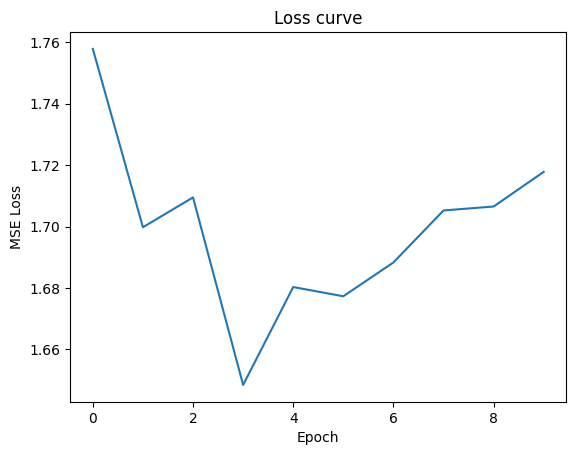

In [19]:
# Plot loss history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss curve')
plt.show()

In [20]:
# Load top cast and crew list and ids
top_cast = pd.read_csv('top_cast.csv')
top_crew = pd.read_csv('top_crew.csv')
CAST_COLS_ORDER = [int(x.split('_')[1]) for x in train_dataset.cast_cols]
CREW_COLS_ORDER = [int(x.split('_')[1]) for x in train_dataset.crew_cols]

In [21]:
def get_cast_tensor(cast_names):
    cast_tensor = torch.zeros(NUM_CAST, device=DEVICE)
    for name in cast_names:
        if name in top_cast['name'].values:
            cast_tensor[CAST_COLS_ORDER.index(top_cast[top_cast['name'] == name]['id'].values[0])] = 1
    return cast_tensor

def get_crew_tensor(crew_names):
    crew_tensor = torch.zeros(NUM_CREW, device=DEVICE)
    for name in crew_names:
        if name in top_crew['name'].values:
            crew_tensor[CREW_COLS_ORDER.index(top_crew[top_crew['name'] == name]['id'].values[0])] = 1
    return crew_tensor

In [22]:
GENRE_COLS_ORDER = [x.split('_')[1] for x in train_dataset.genre_cols]

def get_genre_tensor(genres):
    genre_tensor = torch.zeros(NUM_GENRES, device=DEVICE)
    for genre in genres:
        if genre in GENRE_COLS_ORDER:
            genre_tensor[GENRE_COLS_ORDER.index(genre)] = 1
    return genre_tensor

In [23]:
# movies is a list of dicts having the key/values: overview: string, genre_list: list of strings, original_language: string (like en), budget: float,
# cast: list of names as strings, crew: list of names as strings
def predict_revenues(movies, device):
    inputs = []
    for movie in movies:
        encoded = tokenizer.encode_plus(movie['overview'], add_special_tokens=True, max_length=256, padding='max_length', truncation=True, return_tensors='pt').to(device)
        input_ids = encoded["input_ids"].squeeze()
        attention_mask = encoded["attention_mask"].squeeze()

        genres = get_genre_tensor(movie['genre_list'])

        language_one_hot = [0] * len(train_dataset.original_language_cols)
        language_one_hot[train_dataset.original_language_cols.index('original_language_' + movie['original_language'])] = 1
        original_language = torch.tensor(language_one_hot, dtype=torch.float).to(device)

        cast = get_cast_tensor(movie['cast'])
        crew = get_crew_tensor(movie['crew'])

        if 'budget' in movie:
            budget = torch.tensor([movie['budget'] / 1e8], dtype=torch.float).to(device)
            budget_unknown = torch.tensor([0], dtype=torch.float).to(device)
        else:
            budget = torch.tensor([0], dtype=torch.float).to(device)
            budget_unknown = torch.tensor([1], dtype=torch.float).to(device)

        inputs.append(torch.cat((
            input_ids,
            attention_mask,
            original_language,
            cast,
            crew,
            genres,
            budget,
            budget_unknown
        )))

    inputs = torch.stack(inputs)

    # Predict
    with torch.no_grad():
        prediction = model(inputs)
    return (1e8 * prediction).tolist()

In [24]:

test_movies = [
    {
        'title': 'Oppenheimer',
        'overview': "The story of American scientist, J. Robert Oppenheimer, and his role in the development of the atomic bomb.",
        'genre_list': ['Drama', 'History', 'Thriller'],
        'original_language': 'en',
        'budget': 1e8,
        'cast': ['Cillian Murphy', 'Emily Blunt', 'Matt Damon', 'Robert Downey Jr.'],
        'crew': ['Christopher Nolan']
    },
    {
        'title': 'Barbie',
        'overview': "Barbie suffers a crisis that leads her to question her world and her existence.",
        'genre_list': ['Adventure', 'Comedy', 'Fantasy'],
        'original_language': 'en',
        'budget': 1.45e8,
        'cast': ['Margot Robbie', 'Emma Mackey', 'Ryan Gosling', 'Issa Rae'],
        'crew': ['Greta Gerwig']
    },
    {
        'title': 'Everything Everywhere All at Once',
        'overview': "A middle-aged Chinese immigrant is swept up into an insane adventure in which she alone can save existence by exploring other universes and connecting with the lives she could have led.",
        'genre_list': ['Action', 'Adventure', 'Comedy'],
        'original_language': 'en',
        'budget': 25e6,
        'cast': ['Michelle Yeoh', 'Stephanie Hsu', 'Jamie Lee Curtis'],
        'crew': ['Daniel Kwan', 'Daniel Scheinert']
    }
]

test_movie_actual_revenues = [1.1e9, 1.44e9, 140e6]

revenue_preds = predict_revenues(test_movies, DEVICE)

for i in range(len(test_movies)):
    print("Predicted revenue for ", test_movies[i]['title'], ": ", revenue_preds[i], " USD", "Actual revenue: ", test_movie_actual_revenues[i], " USD")

Predicted revenue for  Oppenheimer :  [524946368.0]  USD Actual revenue:  1100000000.0  USD
Predicted revenue for  Barbie :  [196011360.0]  USD Actual revenue:  1440000000.0  USD
Predicted revenue for  Everything Everywhere All at Once :  [57338124.0]  USD Actual revenue:  140000000.0  USD
